# Final Project

## Names: Mia Schildbach, Aarya Timilsina, Sierra Zhang

- **ACKNOWELDGE ALL EXTERNAL SOURCES HERE:** Give a brief summary of any external sources you used. Ex:
    - Google AI to debug some of the codes
    - Used ChatGPT to generate some of the print statements
    - Used solutions for previous labs 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold

# We will turn of the future warnings that xgboost gives us
import warnings   
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. The Data

The dataset we chose is [Santander Customer Transaction Prediction](https://www.kaggle.com/competitions/santander-customer-transaction-prediction) where:

* Outcome variable: Binary categorical, purchase made or no purchase made
* Predictor variables: $p = 200$
* Number of observations:
    * Training set: $n_{train} = 200,000$
    * Test set: $n_{test} = 200,000$
* Score/metric used for the [leaderboard](https://www.kaggle.com/competitions/santander-customer-transaction-prediction): 
ROC-AUC

In [3]:
# Load all datasets here. 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


## 2. Exploratory Data Analysis and Feature Engineering

MISSING VALUES:
Train total missing: 0
Test total missing: 0
 No missing values found

TARGET DISTRIBUTION:
target
0    179902
1     20098
Name: count, dtype: int64
Transaction rate: 10.05%
Original features: 200
Features: 204
Added: mean, std, max, min
Top 20 features by correlation with target:
var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
var_174    0.061669
var_22     0.060558
var_21     0.058483
var_99     0.058367
var_166    0.057773
var_80     0.057609
var_190    0.055973
var_2      0.055870
var_165    0.055734
var_13     0.055156
var_148    0.055011
dtype: float64


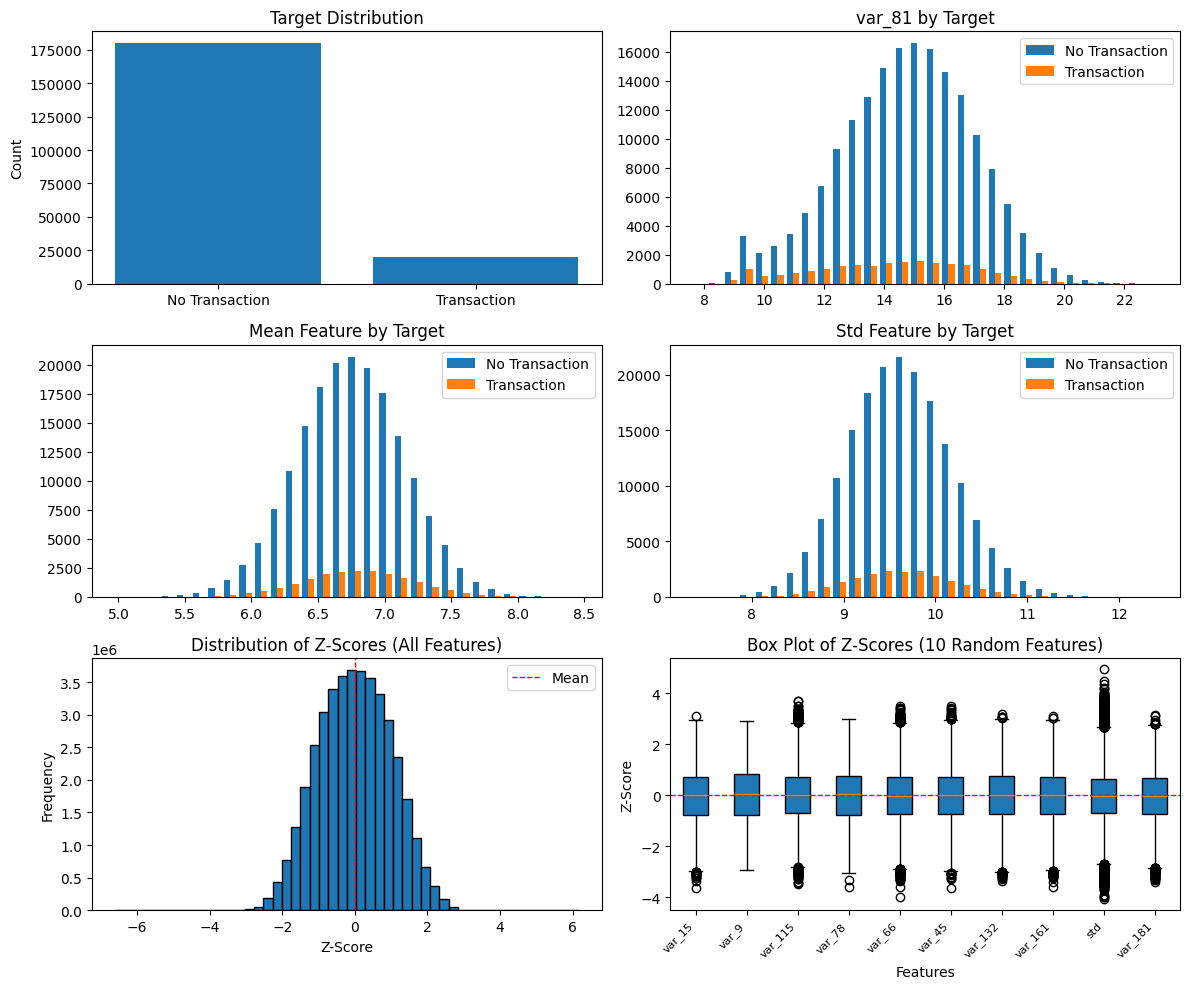

Text(0.5, 1.0, 'Correlation Heatmap - Top 10 Features')

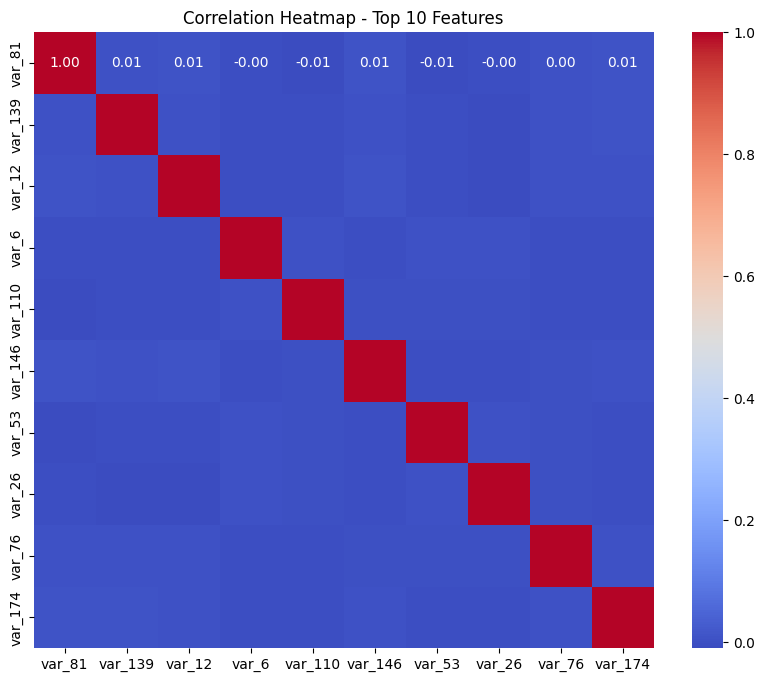

In [6]:
# Check for missing values
print("MISSING VALUES:")
train_missing = train.isnull().sum().sum()
test_missing = test.isnull().sum().sum()
print(f"Train total missing: {train_missing}")
print(f"Test total missing: {test_missing}")

if train_missing > 0:
    print("Train columns with missing values:")
    missing_cols = train.isnull().sum()
    print(missing_cols[missing_cols > 0])

if test_missing > 0:
    print("\nTest columns with missing values:")
    missing_cols = test.isnull().sum()
    print(missing_cols[missing_cols > 0])

# Filling in the missing values with median if any exists
if train_missing > 0 or test_missing > 0:
    print(" Filling missing values with median...")
    train.fillna(train.median(), inplace=True)
    test.fillna(test.median(), inplace=True)
    print(" Missing values filled")
else:
    print(" No missing values found")

# Explore the data more

print("\nTARGET DISTRIBUTION:")
print(train['target'].value_counts())
print(f"Transaction rate: {train['target'].mean():.2%}") # percentage that made a transaction

#creating a dataset of just sales 

train_sale_subset = train[train["target"] == 1]

train_ids = train['ID_code']
test_ids = test['ID_code']

# Separating features and target
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop('ID_code', axis=1)

# Feature engineering

X['mean'] = X.mean(axis=1)
X['std'] = X.std(axis=1)
X['max'] = X.max(axis=1)
X['min'] = X.min(axis=1)


print(f"Original features: 200")
print(f"Features: {X.shape[1]}")
print(f"Added: mean, std, max, min")

# Checking for correlation with target
correlations = pd.DataFrame(X).corrwith(y).abs().sort_values(ascending=False)
print("Top 20 features by correlation with target:")
print(correlations.head(20))

# Visualizations

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Target distribution
axes[0, 0].bar(['No Transaction', 'Transaction'], y.value_counts().values)
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_ylabel('Count')

# Top correlated feature
top_feature = correlations.index[0]
axes[0, 1].hist([X[y==0][top_feature], X[y==1][top_feature]], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[0, 1].set_title(f'{top_feature} by Target')
axes[0, 1].legend()


# Mean feature by target
axes[1, 0].hist([X[y==0]['mean'], X[y==1]['mean']], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[1, 0].set_title('Mean Feature by Target')
axes[1, 0].legend()


# Standard deviation feature by target
axes[1, 1].hist([X[y==0]['std'], X[y==1]['std']], 
                label=['No Transaction', 'Transaction'], bins=30)
axes[1, 1].set_title('Std Feature by Target')
axes[1, 1].legend()


# Calculate z-scores for all features
from scipy import stats
X_zscore = stats.zscore(X)

# Select 10 random features for boxplot
np.random.seed(42)  
selected_features = np.random.choice(X.columns, size=10, replace=False)

#Histogram of z-scores 
axes[2, 0].hist(X_zscore.values.flatten(), bins=50, edgecolor='black')
axes[2, 0].set_title('Distribution of Z-Scores (All Features)')
axes[2, 0].set_xlabel('Z-Score')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].axvline(x=0, color='r', linestyle='--', linewidth=1, label='Mean')
axes[2, 0].legend()

#Box plot of z-scores for 10 selected features
axes[2, 1].boxplot(X_zscore[selected_features].values, vert=True, patch_artist=True)
axes[2, 1].set_title('Box Plot of Z-Scores (10 Random Features)')
axes[2, 1].set_xlabel('Features')
axes[2, 1].set_ylabel('Z-Score')
axes[2, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[2, 1].set_xticklabels(selected_features, rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

# Top features correlation heatmap
top_10 = correlations.head(10).index
corr_matrix = X[top_10].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap - Top 10 Features')


## 4. Data preparation pipelines and pre-processing

In [7]:
# Create pipeline with different scaling and PCA options
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


# Using subset of data for faster results
subset_size = 10000  # Use only 10k samples for grid search
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, train_size=subset_size, random_state=42, stratify=y_train
)
print(f"\nUsing subset of {subset_size} samples for grid search")

Train set: 160000 samples
Validation set: 40000 samples

Using subset of 10000 samples for grid search


## 5. Model selection and hyperparameter tuning

Perform all model selection and hyperpareter tuning here. Create separate pipelines here

In [8]:
# Logistic Regression Model 

#Lr pipeline
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Will be replaced in grid search
    ('pca', PCA()),  # Will be replaced in grid search
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

#Lr params
lr_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'pca__n_components': [None, 5, 10, 25, 50, 100],
    'model__C': [0.1, 1]
}

#lr_gridsearch
lr_gridsearch = GridSearchCV(
    lr_pipe, 
    lr_params, 
    cv=3,  
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

lr_gridsearch.fit(X_train_subset, y_train_subset)

print(f"\nBest parameters:")
print(lr_gridsearch.best_params_)
print(f"\nBest CV AUC: {lr_gridsearch.best_score_:.4f}")

# Evaluate on validation set full
val_auc = roc_auc_score(y_val, lr_gridsearch.predict_proba(X_val)[:, 1])
print(f"Validation AUC: {val_auc:.4f}")

# Save best preprocessing pipeline
best_preprocessing = lr_gridsearch.best_estimator_

# Decision Tree Classifier 
#Based off code from my (Mia's) lab 11, and Aarya's code above 

tree_pipe = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA()),
    ('model', DecisionTreeClassifier(random_state=42))
])

tree_parms = {
    'model__max_depth': [2,3,4],
    'model__min_samples_split': [10,20,40],
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'pca__n_components': [None, 5, 10, 25, 50, 100]
}

#tree_grid_res = GridSearchCV(
    #estimator = tree_pipe, 
    #param_grid = tree_parms, 
    #cv=3, 
    #scoring = 'roc_auc').fit(X_train_subset, y_train_subset)

#print(tree_grid_res.best_estimator_)
#print(tree_grid_res.best_score_)

#sale_tree = tree_grid_res.best_estimator_

# Support Vector Classifier

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=42))
])

svc_parms = {
    'model__kernel': ['rbf', 'poly', 'linear'],
    'model__C' :  [0.1, 1, 10], 
    'model__class_weight': [None, 'balanced']
}

#svc_grid_res = GridSearchCV(
   # estimator = svc_pipe, 
   # param_grid = svc_parms, 
   # cv=3,
   # scoring = 'roc_auc').fit(X_train_subset, y_train_subset)

#print(svc_grid_res.best_estimator_)
#print(svc_grid_res.best_score_)

#XGboost model 
# code based on example code from lab 10
#used google's ai overview to help with debugging 
import warnings   # We will turn of the future warnings that xgboost gives us
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost as xgb


import matplotlib.pyplot as plt

## Xgboots pipeline
xg_pipe = Pipeline([
    ('model', xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state= 42))
])

## Xgboost params
xg_parms = {
    'model__learning_rate': [0.01, 0.3,0.9],
    'model__max_depth': [1,3,5],
    'model__reg_alpha': [0,2,30],
    'model__reg_lambda': [0,2,30],
    'model__n_estimator': [100, 300,500]
}

## Xgboost Grid Search
#from sklearn.model_selection import GridSearchCV
#xg_grid_res = GridSearchCV(
    #estimator = xg_pipe, 
    #param_grid = xg_parms, 
    #scoring= 'roc_auc',
    #cv=3).fit(X_train_subset, y_train_subset)

## Print results
#print(xg_grid_res.best_estimator_)
#print(xg_grid_res.best_params_)
#print(xg_grid_res.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters:
{'model__C': 1, 'pca__n_components': None, 'scaler': None}

Best CV AUC: 0.8381
Validation AUC: 0.8495


In [10]:
# Weighted ensemble
import warnings   # We will turn of the future warnings that xgboost gives us
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost as xgb

# Model 1: Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1, random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict_proba(X_val)[:, 1]
lr_auc = roc_auc_score(y_val, lr_preds)
print(f"Logistic Regression AUC: {lr_auc:.4f}")

# Model 2: SVC
#svc_model = SVC(probability=True, C=0.1, class_weight='balanced', random_state=42)
#svc_model.fit(X_train, y_train)
#svc_preds = svc_model.predict_proba(X_val)[:, 1]
#svc_auc = roc_auc_score(y_val, svc_preds)
#print(f"SVC AUC: {svc_auc:.4f}")

# Model 3: XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, 
                              learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_preds)
print(f"XGBoost AUC: {xgb_auc:.4f}")

# Model 4: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                  class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, rf_preds)
print(f"Random Forest AUC: {rf_auc:.4f}")

# Weighted average (assign weights based on individual performance)
# Option 1: Equal weights
equal_weighted_preds = (lr_preds + xgb_preds + rf_preds) / 3
equal_weighted_auc = roc_auc_score(y_val, equal_weighted_preds)
print(f"\nEqual Weighted Ensemble AUC: {equal_weighted_auc:.4f}")

Logistic Regression AUC: 0.8648
XGBoost AUC: 0.8377
[CV] END model__C=0.1, pca__n_components=None, scaler=StandardScaler(); total time=   0.9s
[CV] END ..model__C=0.1, pca__n_components=None, scaler=None; total time=   1.7s
[CV] END model__C=0.1, pca__n_components=100, scaler=StandardScaler(); total time=   0.7s
[CV] END ...model__C=0.1, pca__n_components=100, scaler=None; total time=   0.8s
[CV] END model__C=1, pca__n_components=5, scaler=StandardScaler(); total time=   0.2s
[CV] END model__C=1, pca__n_components=5, scaler=MinMaxScaler(); total time=   0.2s
[CV] END model__C=1, pca__n_components=10, scaler=StandardScaler(); total time=   0.3s
[CV] END ......model__C=1, pca__n_components=10, scaler=None; total time=   0.2s
[CV] END model__C=1, pca__n_components=25, scaler=MinMaxScaler(); total time=   0.3s
[CV] END ......model__C=1, pca__n_components=25, scaler=None; total time=   0.3s
[CV] END model__C=1, pca__n_components=50, scaler=MinMaxScaler(); total time=   0.4s
[CV] END model__

## 6. Creation of final pipeline

Create your final pipeline here and save it in an object called `pipe_final`. 

In [9]:
auc_scores = {
    "Logistic Regression": lr_auc,
    "XGBoost": xgb_auc,
    "Random Forest": rf_auc,
    "Equal-weighted Ensemble": equal_weighted_auc
}

print("\nAUC scores (best to worst):")
print("-" * 40)

for model, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:25s}: {auc:.4f}")

best_model = max(auc_scores, key=auc_scores.get)
best_auc = auc_scores[best_model]

print("\nBest-performing model/ensemble:")
print(best_model)
print(f"AUC: {best_auc:.4f}")

print("\n" + "=" * 80)
print("GENERATING TEST PREDICTIONS")
print("=" * 80)

# Apply same feature engineering to test set
X_test['mean'] = X_test.mean(axis=1)
X_test['std'] = X_test.std(axis=1)
X_test['max'] = X_test.max(axis=1)
X_test['min'] = X_test.min(axis=1)

# Use the best ensemble method 
test_lr_preds = lr_model.predict_proba(X_test)[:, 1]
#test_svc_preds = svc_model.predict_proba(X_test)[:, 1]
test_xgb_preds = xgb_model.predict_proba(X_test)[:, 1]
test_rf_preds = rf_model.predict_proba(X_test)[:, 1]

#thing I removed from code below to get it to run properly: w_svc * test_svc_preds
test_ensemble_preds = (w_lr * test_lr_preds + 
                       w_xgb * test_xgb_preds + w_rf * test_rf_preds)

# Create submission file
submission = pd.DataFrame({
    'ID_code': test_ids,
    'target': test_ensemble_preds
})
submission.to_csv('ensemble_submission.csv', index=False)
print("\nSubmission file saved as 'ensemble_submission.csv'")

NameError: name 'lr_auc' is not defined

## 7. Creating Submission

* Using `pipe_final`, create a data frame `final_submission` that has your predictions and write to `final_submission.csv` that you can submit on Kaggle. Note the format of `final_submission.csv` has to match that `example_submission.csv` exactly.
* Take a screen shot of your final leaderboard score and ensure it displays below
* Run the `RepeatedKFold()` as you did in PS3. 


* Keep track of at least one score a day

In [ ]:
# Apply pipe_final to create final_submission data frame here:

# GENERATE SUBMISSION.CSV WITH BEST MODEL
# Apply same feature engineering to test set 
X_test['mean'] = X_test.mean(axis=1)
X_test['std'] = X_test.std(axis=1)
X_test['max'] = X_test.max(axis=1)
X_test['min'] = X_test.min(axis=1)

print(f"Test features after engineering: {X_test.shape[1]}")

# Generate predictions based on best model
if best_model == "Logistic Regression":
    test_predictions = lr_model.predict_proba(X_test)[:, 1]
elif best_model == "XGBoost":
    test_predictions = xgb_model.predict_proba(X_test)[:, 1]
elif best_model == "Random Forest":
    test_predictions = rf_model.predict_proba(X_test)[:, 1]
elif best_model == "Equal-weighted Ensemble":
    test_lr_preds = lr_model.predict_proba(X_test)[:, 1]
    test_xgb_preds = xgb_model.predict_proba(X_test)[:, 1]
    test_rf_preds = rf_model.predict_proba(X_test)[:, 1]
    test_predictions = (test_lr_preds + test_xgb_preds + test_rf_preds) / 3

# Create submission file
submission = pd.DataFrame({
    'ID_code': test_ids,
    'target': test_predictions
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
# Write to CSV. Note setting index=True will output the row indices `PassengerId`
# as the first column of the CSV
final_submission.to_csv('data/final_submission.csv', index=True)

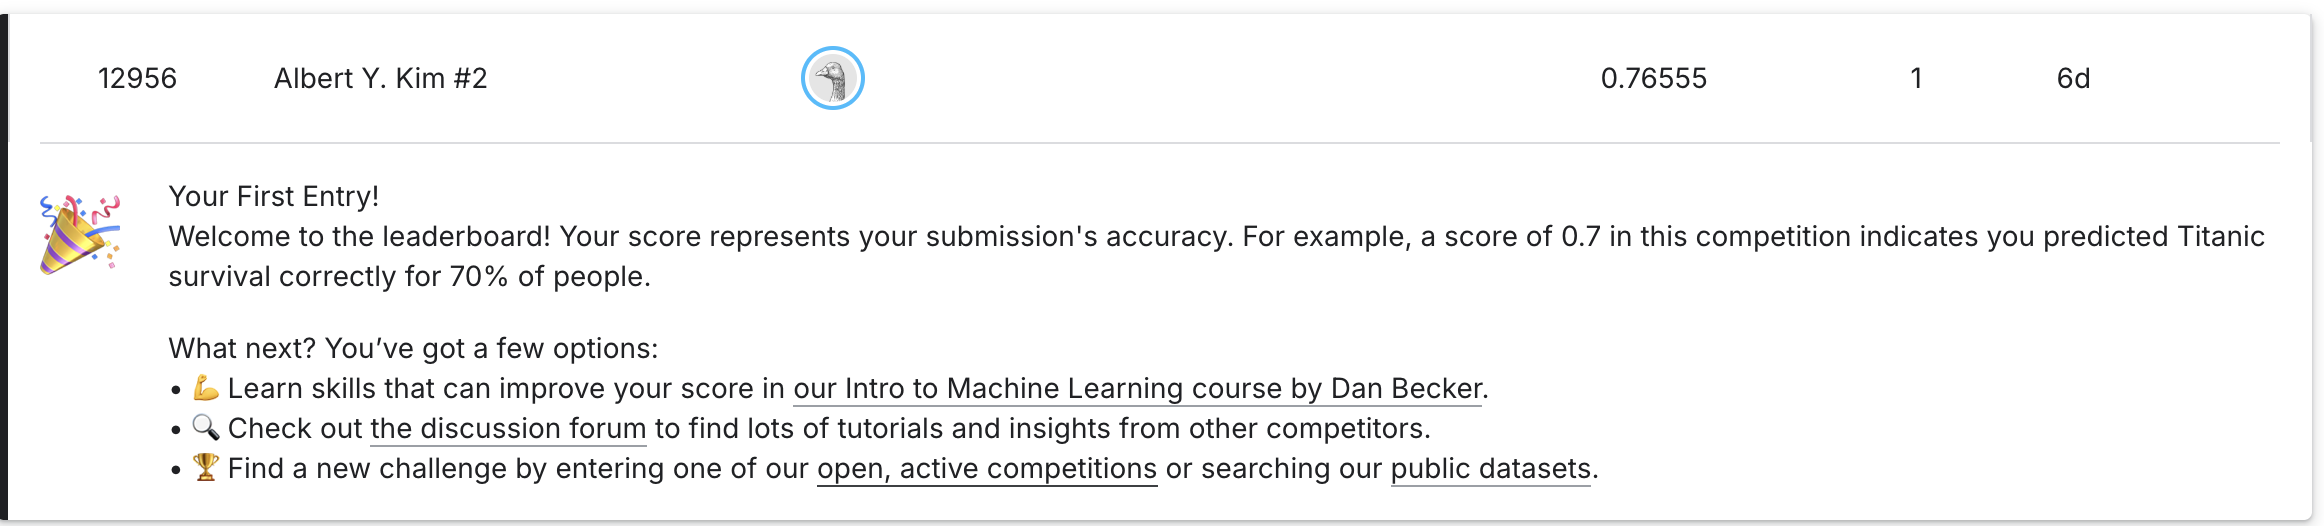

In [ ]:
from IPython.display import Image
Image("images/leaderboard.png")

In [ ]:
cv_final = RepeatedKFold(n_splits=5, n_repeats=10, random_state=500)
scores_final = cross_val_score(pipe_final, X_train, y_train, scoring='accuracy', cv=cv_final)
print(f'Mean accuracy: {np.mean(scores_final):.3f}')

## 8. Appendix

Please anything extra that you don't feel is central, but would still like to keep here